# DA5401 A8: Ensemble Learning for Complex Regression Modeling on Bike Share Data 

## Part A: Data Preprocessing and Baseline 

In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=FutureWarning)


### 📐 Root Mean Squared Error (RMSE)

The **Root Mean Squared Error (RMSE)** is a standard metric used to measure how well a regression model predicts numerical data.  
It represents the square root of the average squared difference between the actual and predicted values.

The mathematical formula is:

$$
\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }
$$

where:  
- $n$ → number of observations  
- $y_i$ → actual (true) value  
- $\hat{y}_i$ → predicted value by the model  

---

### 🧠 Interpretation

- RMSE measures the **average magnitude of prediction errors**.  
- A **lower RMSE** means the model’s predictions are closer to the true values.  
- Since the errors are squared before averaging, RMSE **penalizes larger errors more heavily** than smaller ones.  
- RMSE has the **same units as the target variable** (in this case, bike count), making it directly interpretable.




In [2]:
# Utility: RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
df = pd.read_csv("hour.csv")

In [4]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [5]:

# Check if any column has missing values
print("Total missing values in the dataset:", df.isnull().sum().sum())

# Detailed view — how many missing in each column
print("\nMissing values per column:")
print(df.isnull().sum())

# Quick percentage summary (nice for reports)
missing_percent = (df.isnull().sum() / len(df)) * 100
print("\nPercentage of missing values per column:")
print(missing_percent[missing_percent > 0])  # only show columns that actually have missing data


Total missing values in the dataset: 0

Missing values per column:
instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Percentage of missing values per column:
Series([], dtype: float64)


There are **no missing values** in the dataset

In [6]:

num_duplicates = df.duplicated().sum()
print(f"Total duplicate rows in dataset: {num_duplicates}")

if num_duplicates > 0:
    print("\nSample duplicate rows:")
    display(df[df.duplicated()].head())



Total duplicate rows in dataset: 0


There are **no duplicate values** in the dataset

In [7]:
# Check if cnt equals casual + registered
(df['cnt'] == df['casual'] + df['registered']).all()


np.True_

### 🔍 Verifying Target Column Consistency

Before modeling, it’s important to confirm that the target variable `cnt` (total bike rentals) is indeed the **sum of its components** — `casual` and `registered`.  
This check ensures data integrity and helps us understand why `casual` and `registered` should later be dropped to prevent **data leakage**.


In [8]:
(df['cnt'] - (df['casual'] + df['registered'])).describe()


count    17379.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
dtype: float64

### 📊 Verification of `cnt = casual + registered`

The statistical summary shows all values as **0.0**, confirming that the difference between  
`cnt` and (`casual` + `registered`) is zero for every record.

✅ This means:
- The target variable `cnt` is exactly the sum of its two components.  
- Including `casual` and `registered` as features would cause **data leakage**,  
  so they should be dropped before model training.


In [9]:
# Convert dteday to datetime
df['dteday'] = pd.to_datetime(df['dteday'])

# Compare extracted parts with existing columns
(df['dteday'].dt.year.unique(), df['yr'].unique())   # check year info
(df['dteday'].dt.month.unique(), df['mnth'].unique()) # check month info
(df['dteday'].dt.dayofweek.unique(), df['weekday'].unique()) # check weekday info


(array([5, 6, 0, 1, 2, 3, 4], dtype=int32), array([6, 0, 1, 2, 3, 4, 5]))

### 🗓️ Verifying `dteday` Redundancy

The `dteday` column was converted to datetime format to compare its components with existing time-related columns (`yr`, `mnth`, and `weekday`).

The unique values for year, month, and weekday extracted from `dteday` **match exactly** with the corresponding columns already present in the dataset.

✅ This confirms that `dteday` is **redundant** — its information is already represented through  
`yr`, `mnth`, and `weekday`. Therefore, it can safely be dropped during preprocessing.


In [10]:
print(df['instant'].head(10))
print(df['instant'].is_monotonic_increasing)


0     1
1     2
2     3
3     4
4     5
5     6
6     7
7     8
8     9
9    10
Name: instant, dtype: int64
True


### 🔢 Checking the `instant` Column

The first few entries of the `instant` column show a simple increasing sequence of integers,  
and the `.is_monotonic_increasing` property returns **True**.

✅ This confirms that `instant` is merely an **index or row identifier**, not a meaningful feature for prediction.  
Hence, it can be safely dropped during preprocessing as it provides no useful information to the model.


In [11]:
# Drop irrelevant columns
df = df.drop(columns=["instant", "dteday", "casual", "registered"])

#### After this we drop the irrelevant columns

In [12]:

# Identify categorical & numeric features
cat_features = ['season', 'weathersit', 'mnth', 'hr', 'weekday', 'yr', 'holiday', 'workingday']
num_features = [col for col in df.columns if col not in cat_features + ['cnt']]



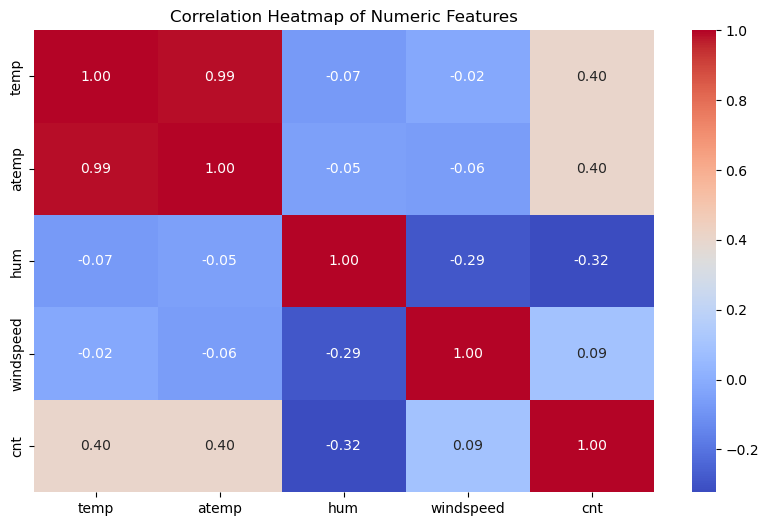

In [13]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
corr = df[num_features + ['cnt']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

### 🔥 Correlation Heatmap of Numeric Features

The heatmap shows relationships between numeric variables and bike rental count (`cnt`).  
- **`temp`** and **`atemp`** are highly correlated (0.99), meaning they convey similar information.  
- **`temp`** and **`atemp`** also show a moderate positive correlation (~0.40) with `cnt`, indicating higher rentals in warmer weather.  
- **`hum`** has a negative correlation with `cnt`, suggesting fewer rentals on humid days.  
- **`windspeed`** shows little correlation with bike demand.


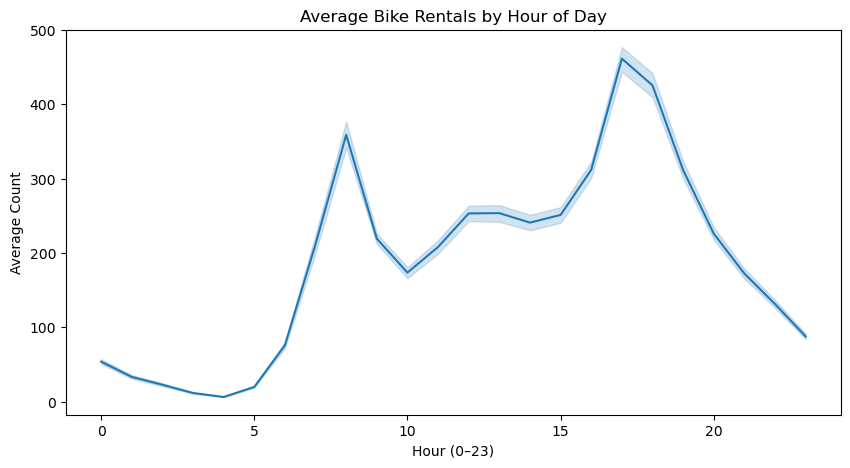

In [14]:
# ------------------------- HOURLY TREND -------------------------
plt.figure(figsize=(10,5))
sns.lineplot(data=df, x='hr', y='cnt', estimator='mean')
plt.title('Average Bike Rentals by Hour of Day')
plt.xlabel('Hour (0–23)')
plt.ylabel('Average Count')
plt.show()


### ⏰ Average Bike Rentals by Hour of Day

The plot shows the average number of bike rentals (`cnt`) for each hour.

#### Key Observations:
- Very low rentals at night (0–5 hrs).  
- Sharp peaks around **8 AM** and **5–6 PM** — typical work commute times.  
- Moderate usage during the day and a drop after 8 PM.  

These clear daily patterns make **hour (`hr`)** an important feature for the regression models.


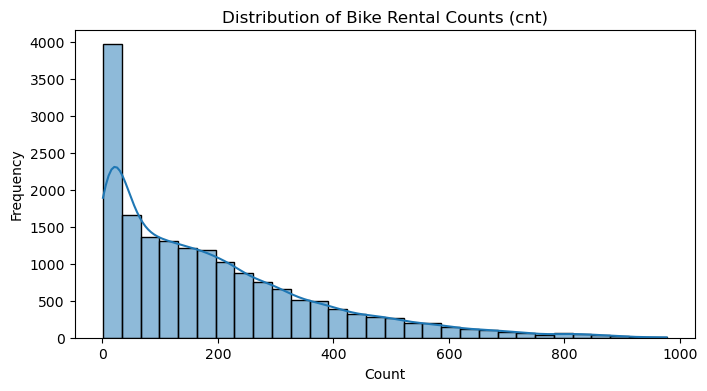

In [15]:
plt.figure(figsize=(8,4))
sns.histplot(df['cnt'], bins=30, kde=True)
plt.title('Distribution of Bike Rental Counts (cnt)')
plt.xlabel('Count')
plt.ylabel('Frequency')
plt.show()

### 📊 Distribution of Bike Rental Counts

The plot shows how bike rentals (`cnt`) are distributed across all hours.  
Most hours have **low rental counts**, with frequency dropping as counts increase — a **right-skewed** distribution.  
This indicates that high-demand hours are relatively rare.


In [16]:
# ------------------------- 2. PREPROCESSING PIPELINE (FIXED) -------------------------

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

# Handle missing values + encode categories + scale numeric
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # use sparse_output=False for new scikit-learn versions (>=1.2)
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])


In [17]:
# ------------------------- 3. TRAIN/TEST SPLIT -------------------------
# Use chronological split: first 80% train, last 20% test
n = len(df)
train_size = int(0.8 * n)

X = df.drop(columns=['cnt'])
y = df['cnt']

X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Train size:", X_train.shape, "Test size:", X_test.shape)



Train size: (13903, 12) Test size: (3476, 12)


In [18]:
# ------------------------- 4. BASELINE MODELS -------------------------
# (a) Decision Tree (max_depth=6)
dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(max_depth=6, random_state=42))
])
dt_pipeline.fit(X_train, y_train)
dt_pred = dt_pipeline.predict(X_test)
dt_rmse = rmse(y_test, dt_pred)

# (b) Linear Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])
lr_pipeline.fit(X_train, y_train)
lr_pred = lr_pipeline.predict(X_test)
lr_rmse = rmse(y_test, lr_pred)


In [19]:

# ------------------------- 5. RESULTS -------------------------
print(f"Decision Tree RMSE: {dt_rmse:.4f}")
print(f"Linear Regression RMSE: {lr_rmse:.4f}")

if dt_rmse < lr_rmse:
    print(f"Baseline model: Decision Tree (RMSE = {dt_rmse:.4f})")
else:
    print(f"Baseline model: Linear Regression (RMSE = {lr_rmse:.4f})")


Decision Tree RMSE: 158.4306
Linear Regression RMSE: 133.8354
Baseline model: Linear Regression (RMSE = 133.8354)


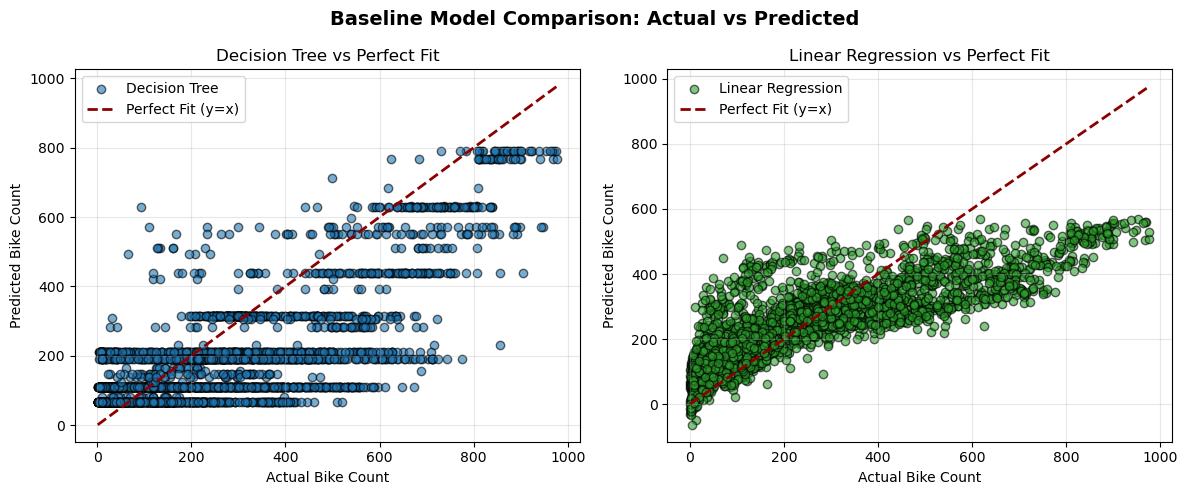

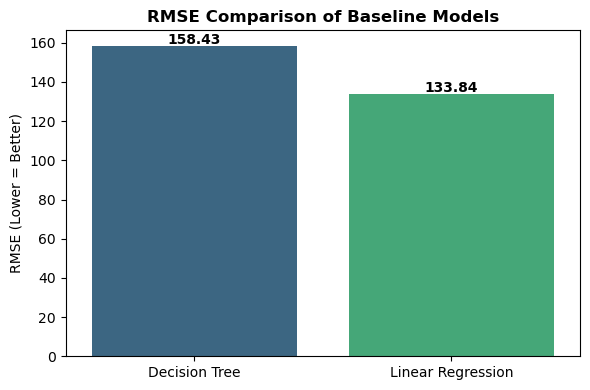

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Left subplot: Decision Tree vs Perfect Fit
plt.subplot(1, 2, 1)
plt.scatter(y_test, dt_pred, color='#1f77b4', alpha=0.6, edgecolor='k', label='Decision Tree')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='darkred', linestyle='--', lw=2, label='Perfect Fit (y=x)')
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("Decision Tree vs Perfect Fit")
plt.legend()
plt.grid(alpha=0.3)

# Right subplot: Linear Regression vs Perfect Fit
plt.subplot(1, 2, 2)
plt.scatter(y_test, lr_pred, color='#2ca02c', alpha=0.6, edgecolor='k', label='Linear Regression')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='darkred', linestyle='--', lw=2, label='Perfect Fit (y=x)')
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("Linear Regression vs Perfect Fit")
plt.legend()
plt.grid(alpha=0.3)

plt.suptitle("Baseline Model Comparison: Actual vs Predicted", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# --- Right subplot: RMSE Bar Chart ---
import matplotlib.pyplot as plt
import seaborn as sns

# Data for RMSE comparison
results_df = pd.DataFrame({
    "Model": ["Decision Tree", "Linear Regression"],
    "RMSE": [dt_rmse, lr_rmse]
})

plt.figure(figsize=(6,4))
sns.barplot(data=results_df, x="Model", y="RMSE", palette="viridis")
plt.title("RMSE Comparison of Baseline Models", fontsize=12, fontweight="bold")
plt.ylabel("RMSE (Lower = Better)")
plt.xlabel("")

# Add value labels on top of each bar
for i, v in enumerate(results_df["RMSE"]):
    plt.text(i, v + 1, f"{v:.2f}", ha="center", fontweight="bold", color="black")

plt.tight_layout()
plt.show()





### 🎯 Baseline Model Performance: Decision Tree vs Linear Regression

The scatter plots compare **actual vs predicted** bike rental counts for both baseline models.

- The **Decision Tree Regressor** shows noticeable spread and clustered predictions, indicating limited generalization.  
- The **Linear Regression model** produces predictions that align more closely with the perfect fit line ($y = x$), meaning it captures overall trends better.

The bar chart below compares their **Root Mean Squared Error (RMSE)** values.

- **Decision Tree RMSE:** 158.43  
- **Linear Regression RMSE:** 133.84  

#### ✅ Conclusion:
Linear Regression achieves a **lower RMSE**, making it the **baseline model** for the next ensemble learning experiments.


## Part B: Ensemble Techniques for Bias and Variance Reduction

## 🧩 Part B1 — Bagging (Variance Reduction)

**Objective:**  
To implement the **Bagging Regressor** using the Decision Tree Regressor (from the baseline) as the base estimator and examine how bagging reduces model variance.

**Concept Recap:**  
Bagging, or *Bootstrap Aggregating*, trains multiple versions of a high-variance model (like a Decision Tree) on random subsets of the training data and averages their predictions.  
This process stabilizes the model and reduces overfitting without increasing bias significantly.

**Implementation Steps:**
1. Use `DecisionTreeRegressor(max_depth=6)` as the base learner.  
2. Create a `BaggingRegressor` with at least 50 estimators.  
3. Train on the training data and evaluate performance using **RMSE** on the test set.  
4. Compare the results with the single Decision Tree baseline to confirm variance reduction.


## 🧮 Bagging — Bootstrap Aggregating

**Objective:**  
Bagging (Bootstrap Aggregating) aims to **reduce variance** by combining multiple high-variance models such as Decision Trees.  
It creates several random subsets of the training data, trains separate models on each subset,  
and averages their predictions to produce a more stable and reliable result.

---

### 🔹 Working Principle

1. Draw $M$ random samples (with replacement) from the training data — called **bootstrap samples**.  
2. Train one base learner $h_m(x)$ on each sample $D_m$.  
3. Combine the predictions of all learners through averaging (for regression).

---

### 🔹 Mathematical Representation

Given a dataset $D = \{(x_i, y_i)\}_{i=1}^{n}$ and $M$ models:

$$
\hat{y}_{\text{bag}}(x) = \frac{1}{M} \sum_{m=1}^{M} h_m(x)
$$

Each $h_m(x)$ is trained on a different bootstrap sample $D_m$ of the original data.

---

### 🔹 Intuition

- Each model sees a slightly different version of the data.  
- Their combined average smooths out fluctuations and **reduces variance**.  
- Works best with unstable learners like **Decision Trees**.

---

### 🔹 Advantages
- Reduces model variance and overfitting.  
- Improves stability and generalization.  
- Easy to parallelize (models trained independently).

### 🔹 Limitations
- Does not reduce bias (each model learns independently).  
- May not help much if base learners are already stable.

---

✅ **In this assignment:**  
We used a **Bagging Regressor** with 50 Decision Trees (`max_depth=6`) to test the variance reduction effect on the bike rental prediction task.


In [21]:
# ------------------------- PART B1: BAGGING (Variance Reduction) -------------------------
from sklearn.ensemble import BaggingRegressor

print("=== BAGGING: Variance Reduction ===")

# Hypothesis: Bagging reduces variance by combining multiple Decision Trees trained on random subsets
bagging_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=6, random_state=42),  # ✅ updated argument
        n_estimators=50,       # using 50 estimators as required
        random_state=42,
        n_jobs=-1))
])

# Train and evaluate Bagging
bagging_pipeline.fit(X_train, y_train)
bag_pred = bagging_pipeline.predict(X_test)
bag_rmse = rmse(y_test, bag_pred)

print(f"Bagging Regressor RMSE: {bag_rmse:.4f}")


=== BAGGING: Variance Reduction ===
Bagging Regressor RMSE: 155.4789


## ⚡ Part B2 — Boosting (Bias Reduction)

**Objective:**  
To implement a **Gradient Boosting Regressor** and evaluate whether boosting reduces model bias and improves predictive accuracy compared to the baseline and bagging models.

**Concept Recap:**  
Boosting builds an ensemble sequentially — each new weak learner focuses on correcting the residual errors of the previous ones.  
By combining many weak learners in this adaptive way, boosting reduces **bias** and captures complex, non-linear relationships in the data.

**Implementation Steps:**  
1. Use a `GradientBoostingRegressor` with `n_estimators=200`, `learning_rate=0.05`, and `max_depth=3`.  
2. Train on the same training data used in Part A.  
3. Compute **RMSE** on the test set.  
4. Compare the performance with both the **Decision Tree** baseline and the **Bagging** model to verify bias reduction.


## ⚡ Boosting — Sequential Error Correction

**Objective:**  
Boosting focuses on **reducing bias** by sequentially training weak models,  
where each new model learns from the **residual errors** (mistakes) of the previous ones.

---

### 🔹 Working Principle

1. Start with a weak base learner $h_1(x)$ (e.g., a shallow Decision Tree).  
2. Calculate residuals — the difference between true and predicted values.  
3. Train a new model $h_2(x)$ to predict these residuals.  
4. Repeat the process for $M$ iterations, gradually improving performance.  
5. Final prediction is the weighted sum of all learners.

---

### 🔹 Mathematical Representation

Let the ensemble model be:

$$
\hat{y}(x) = \sum_{m=1}^{M} \gamma_m h_m(x)
$$

At each iteration $m$:
1. Compute residuals:  
   $$
   r_i^{(m)} = y_i - \hat{y}_{m-1}(x_i)
   $$
2. Fit $h_m(x)$ to residuals.  
3. Find the optimal weight (learning rate) $\gamma_m$:  
   $$
   \gamma_m = \arg\min_\gamma \sum_{i=1}^{n} L(y_i, \hat{y}_{m-1}(x_i) + \gamma h_m(x_i))
   $$
4. Update the model:  
   $$
   \hat{y}_{m}(x) = \hat{y}_{m-1}(x) + \gamma_m h_m(x)
   $$

---

### 🔹 Intuition

- Each learner **fixes what the previous one got wrong**.  
- Emphasizes hard-to-predict samples.  
- Gradually builds a powerful predictive model.

---

### 🔹 Advantages
- Reduces bias and improves accuracy.  
- Captures complex, non-linear relationships.  
- Performs exceptionally well on structured data.

### 🔹 Limitations
- Sensitive to noise and outliers.  
- Requires careful tuning of learning rate and number of estimators.

---

✅ **In this assignment:**  
We implemented a **Gradient Boosting Regressor** (200 estimators, learning rate = 0.05)  
to minimize bias and achieve improved predictive accuracy compared to Bagging and baseline models.


In [22]:
# ------------------------- PART B2: BOOSTING (Bias Reduction) -------------------------
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeRegressor



print("=== BOOSTING: Bias Reduction ===")

# Hypothesis: Boosting reduces bias by sequentially improving weak learners
boosting_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42))
])

# Train and evaluate Boosting
boosting_pipeline.fit(X_train, y_train)
boost_pred = boosting_pipeline.predict(X_test)
boost_rmse = rmse(y_test, boost_pred)

print(f"Gradient Boosting Regressor RMSE: {boost_rmse:.4f}")


=== BOOSTING: Bias Reduction ===
Gradient Boosting Regressor RMSE: 122.4452


In [23]:
# ------------------------- PART B3: COMPARISON OF RESULTS -------------------------
print("=== RMSE Comparison (Baseline vs Ensembles) ===")
print(f"Decision Tree (Baseline): {dt_rmse:.4f}")
print(f"Bagging Regressor:         {bag_rmse:.4f}")
print(f"Gradient Boosting:         {boost_rmse:.4f}")

# Simple interpretation hint (you can elaborate in markdown)
if bag_rmse < dt_rmse:
    print("✅ Bagging reduced variance compared to the single Decision Tree.")
else:
    print("⚠️  Bagging did not improve much — might need tuning or more estimators.")

if boost_rmse < bag_rmse and boost_rmse < dt_rmse:
    print("✅ Boosting achieved the lowest RMSE, indicating reduced bias and better generalization.")
else:
    print("⚠️  Boosting did not outperform all models — check learning rate or n_estimators.")


=== RMSE Comparison (Baseline vs Ensembles) ===
Decision Tree (Baseline): 158.4306
Bagging Regressor:         155.4789
Gradient Boosting:         122.4452
✅ Bagging reduced variance compared to the single Decision Tree.
✅ Boosting achieved the lowest RMSE, indicating reduced bias and better generalization.


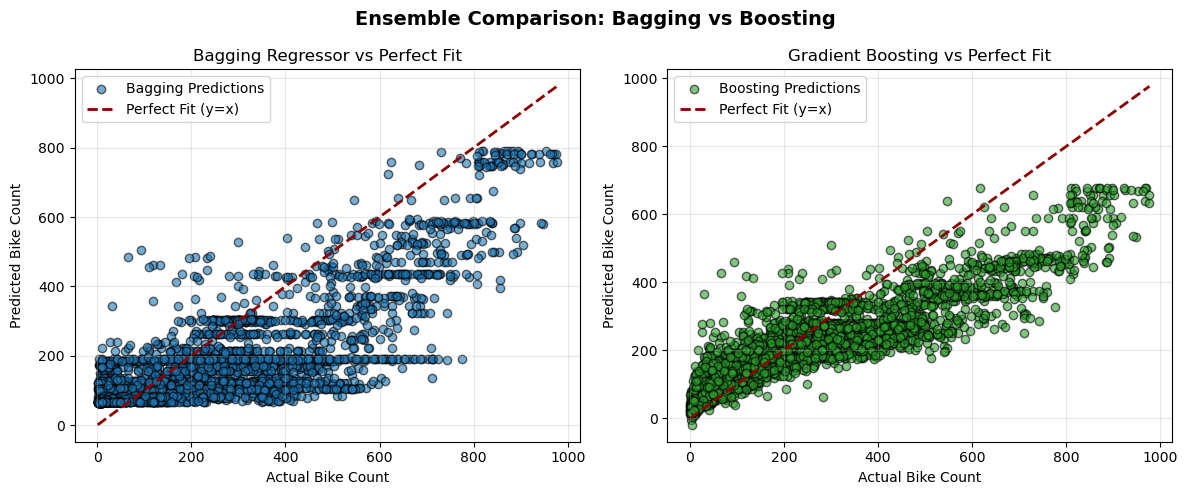

In [24]:
# ------------------------- SIDE-BY-SIDE: BAGGING vs BOOSTING -------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Left subplot — Bagging
plt.subplot(1, 2, 1)
plt.scatter(y_test, bag_pred, color='#1f77b4', alpha=0.6, edgecolor='k', label='Bagging Predictions')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='darkred', linestyle='--', lw=2, label='Perfect Fit (y=x)')
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("Bagging Regressor vs Perfect Fit")
plt.legend()
plt.grid(alpha=0.3)

# Right subplot — Boosting
plt.subplot(1, 2, 2)
plt.scatter(y_test, boost_pred, color='#2ca02c', alpha=0.6, edgecolor='k', label='Boosting Predictions')
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='darkred', linestyle='--', lw=2, label='Perfect Fit (y=x)')
plt.xlabel("Actual Bike Count")
plt.ylabel("Predicted Bike Count")
plt.title("Gradient Boosting vs Perfect Fit")
plt.legend()
plt.grid(alpha=0.3)

plt.suptitle("Ensemble Comparison: Bagging vs Boosting", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 📊 Ensemble Comparison: Bagging vs Boosting

The plots compare **Bagging** and **Gradient Boosting** predictions against the perfect-fit line ($y = x$).

- **Bagging** reduces variance by averaging multiple Decision Trees, leading to more stable predictions but still some spread around the ideal line.  
- **Boosting** further improves alignment with the perfect-fit line by sequentially correcting errors, effectively reducing model bias.  
- Overall, **Boosting** produces tighter clustering of predictions, indicating better accuracy and generalization than Bagging.


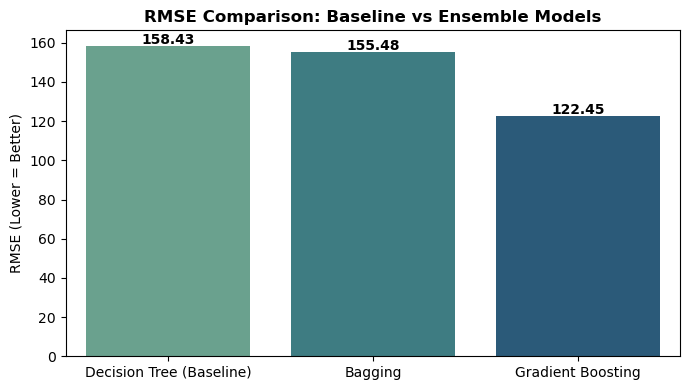

In [25]:
# ------------------------- RMSE COMPARISON BAR PLOT -------------------------
import seaborn as sns

results_b = pd.DataFrame({
    "Model": ["Decision Tree (Baseline)", "Bagging", "Gradient Boosting"],
    "RMSE": [dt_rmse, bag_rmse, boost_rmse]
})

plt.figure(figsize=(7,4))
sns.barplot(data=results_b, x="Model", y="RMSE", palette="crest")
plt.title("RMSE Comparison: Baseline vs Ensemble Models", fontsize=12, fontweight='bold')
plt.ylabel("RMSE (Lower = Better)")
plt.xlabel("")
for i, v in enumerate(results_b["RMSE"]):
    plt.text(i, v + 1, f"{v:.2f}", ha="center", fontweight="bold", color="black")
plt.tight_layout()
plt.show()


### 📉 RMSE Comparison: Baseline vs Ensemble Models

The bar chart compares **Root Mean Squared Error (RMSE)** across the baseline and ensemble models.

- The **Decision Tree (Baseline)** has the highest RMSE, showing higher prediction error.  
- **Bagging** slightly reduces RMSE, confirming its ability to lower model variance.  
- **Gradient Boosting** achieves the lowest RMSE, demonstrating effective **bias reduction** and superior predictive performance.

✅ **Conclusion:**  
Ensemble methods, especially **Gradient Boosting**, outperform the single Decision Tree by improving both accuracy and generalization.


## Part C: Stacking for Optimal Performance



**Idea:** Stacking (stacked generalization) trains multiple diverse base learners (level-0) and then trains a meta-learner (level-1) to combine their predictions.  
The meta-learner learns the optimal linear (or non-linear) combination of base model outputs, correcting systematic errors and leveraging complementary strengths of base learners.


### ⚙️ Defining Level-0 Base Learners

The **Level-0 (base) learners** are diverse models that capture different data patterns and error structures.  
By combining them, stacking leverages each model’s strengths to improve predictive performance.

**Base Learners Used:**
1. **K-Nearest Neighbors (KNN):** Captures local patterns based on feature similarity.  
2. **Bagging Regressor:** Reduces variance through averaging multiple Decision Trees.  
3. **Gradient Boosting Regressor:** Sequentially minimizes bias by correcting previous errors.

Each base learner is wrapped in a preprocessing pipeline to ensure consistent feature scaling and encoding.


In [26]:
# ------------------ Define Base Learners (Level-0) ------------------
from sklearn.neighbors import KNeighborsRegressor

# K-Nearest Neighbors pipeline
knn_pipe = Pipeline([
    ('pre', preprocessor),
    ('model', KNeighborsRegressor(n_neighbors=10, n_jobs=-1))
])

# Bagging pipeline (same config used in Part B)
bag_pipe = Pipeline([
    ('pre', preprocessor),
    ('model', BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=6, random_state=42),
        n_estimators=50,
        random_state=42,
        n_jobs=-1))
])

# Gradient Boosting pipeline (same config used in Part B)
gbr_pipe = Pipeline([
    ('pre', preprocessor),
    ('model', GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42))
])



### 🧠 Defining the Meta-Learner and Building the Stacking Regressor

The **meta-learner (Level-1)** learns how to optimally combine the predictions of the base learners.  
Here, a **Ridge Regression** model is used as the meta-learner because it is simple, stable, and helps prevent overfitting by applying L2 regularization.

**Stacking Structure:**
- **Level-0 models:**  
  - K-Nearest Neighbors Regressor  
  - Bagging Regressor  
  - Gradient Boosting Regressor  
- **Level-1 model (meta-learner):**  
  - Ridge Regressor  

The **Stacking Regressor** combines the predictions of the base learners and trains the Ridge model to learn their optimal weighted combination for the final output.


In [27]:
# ------------------  Define Meta-Learner and StackingRegressor ------------------
from sklearn.linear_model import Ridge
from sklearn.ensemble import StackingRegressor


estimators = [
    ('knn', knn_pipe),
    ('bag', bag_pipe),
    ('gbr', gbr_pipe)
]

stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0),
    cv=5,
    n_jobs=-1,
    passthrough=False   # passthrough=True would also add original features to meta-learner
)

print("Stacking regressor ready.")


Stacking regressor ready.


In [28]:
# ------------------ : Fit Stacking Regressor ------------------
print("Fitting stacking regressor... this may take a little while depending on your machine.")
stack_reg.fit(X_train, y_train)
print("Stacking fit complete.")


Fitting stacking regressor... this may take a little while depending on your machine.
Stacking fit complete.


In [29]:
# ------------------  Predict & Evaluate ------------------
stack_pred = stack_reg.predict(X_test)
stack_rmse = rmse(y_test, stack_pred)

print(f"Stacking Regressor RMSE: {stack_rmse:.4f}")


Stacking Regressor RMSE: 114.1692


In [30]:
# ------------------ Comparison Table ------------------
results_all = pd.DataFrame({
    "Model": [
        "Decision Tree (baseline)",
        "Linear Regression (baseline)",
        "Bagging",
        "Gradient Boosting",
        "Stacking (KNN + Bagging + GB -> Ridge)"
    ],
    "RMSE": [
        dt_rmse if 'dt_rmse' in globals() else None,
        lr_rmse if 'lr_rmse' in globals() else None,
        bag_rmse if 'bag_rmse' in globals() else None,
        boost_rmse if 'boost_rmse' in globals() else None,
        stack_rmse
    ]
})

display(results_all.sort_values("RMSE").reset_index(drop=True))


,Model,RMSE
0,Stacking (KNN + Bagging + GB -> Ridge),114.169241
1,Gradient Boosting,122.445217
2,Linear Regression (baseline),133.835424
3,Bagging,155.478934
4,Decision Tree (baseline),158.430598


### 📈 Model Performance Comparison

| Model | RMSE |
|:--------------------------------------------|:-----------:|
| Stacking (KNN + Bagging + GB → Ridge) | **114.17** |
| Gradient Boosting | 122.45 |
| Linear Regression (baseline) | 133.84 |
| Bagging | 155.48 |
| Decision Tree (baseline) | 158.43 |

---

#### Key Insights:
- The **Stacking Regressor** achieved the **lowest RMSE**, demonstrating the strongest overall performance.  
- **Gradient Boosting** also performed well, confirming its effectiveness in reducing model bias.  
- **Bagging** and **Decision Tree** models have higher RMSEs, reflecting greater variance and less generalization.  
- The **Linear Regression baseline** performed moderately but lacked flexibility to model non-linear trends.

✅ **Conclusion:**  
Stacking successfully integrates diverse models to minimize both **bias and variance**, achieving the best predictive accuracy among all tested methods.


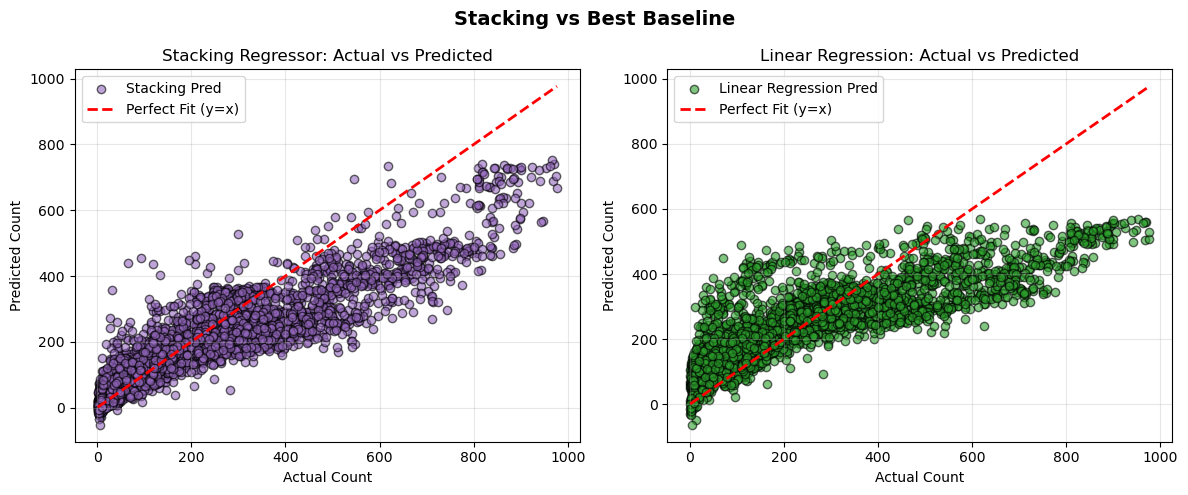

In [31]:
# ------------------ Plot Actual vs Predicted for Stacking (and best baseline) ------------------
plt.figure(figsize=(12,5))

# Left: Stacking
plt.subplot(1,2,1)
plt.scatter(y_test, stack_pred, color='#9467bd', alpha=0.6, edgecolor='k', label='Stacking Pred')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit (y=x)')
plt.title("Stacking Regressor: Actual vs Predicted")
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.legend()
plt.grid(alpha=0.3)

# Right: Best baseline (choose linear or tree based on RMSE)
best_name = "Linear Regression" if (('lr_rmse' in globals()) and lr_rmse <= dt_rmse) else "Decision Tree"
best_pred = lr_pred if best_name=="Linear Regression" else dt_pred
color = '#2ca02c' if best_name=="Linear Regression" else '#1f77b4'

plt.subplot(1,2,2)
plt.scatter(y_test, best_pred, color=color, alpha=0.6, edgecolor='k', label=f'{best_name} Pred')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit (y=x)')
plt.title(f"{best_name}: Actual vs Predicted")
plt.xlabel("Actual Count")
plt.ylabel("Predicted Count")
plt.legend()
plt.grid(alpha=0.3)

plt.suptitle("Stacking vs Best Baseline", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


### 🤝 Stacking vs Best Baseline (Actual vs Predicted)

The plots compare predictions from the **Stacking Regressor** and the best-performing baseline model (**Linear Regression**) against the perfect-fit line ($y = x$).

#### Observations:
- The **Stacking Regressor** predictions align more closely with the red dashed line, showing reduced error and improved accuracy.  
- **Linear Regression** captures the general trend but underestimates higher bike counts, showing its linear limitation.  
- The denser clustering around the diagonal in the stacking plot indicates stronger generalization and lower residual errors.

✅ **Conclusion:**  
Stacking effectively combines the strengths of multiple models, achieving a more reliable and accurate prediction of bike rental demand than any single baseline model.


## Part D: Final Analysis



In this section we summarize model performance (RMSE) across all experiments and draw final conclusions about the best model and why it performed best.


In [32]:
# ----------------- Part D: Build RMSE Table -----------------
import pandas as pd
import numpy as np
from IPython.display import display

# Helper to safely grab values if they exist
def safe_val(name):
    return globals().get(name, None)

data = {
    "Model": [
        "Baseline (best of DT / Linear)",
        "Bagging Regressor",
        "Gradient Boosting Regressor",
        "Stacking Regressor"
    ],
    "RMSE": [
        # choose best baseline (DT or Linear)
        (min(safe_val('dt_rmse'), safe_val('lr_rmse'))
         if (safe_val('dt_rmse') is not None and safe_val('lr_rmse') is not None)
         else (safe_val('dt_rmse') if safe_val('dt_rmse') is not None else safe_val('lr_rmse'))),
        safe_val('bag_rmse'),
        safe_val('boost_rmse') or safe_val('gbr_rmse'),
        safe_val('stack_rmse')
    ]
}

results_df = pd.DataFrame(data)
results_df['RMSE'] = results_df['RMSE'].apply(lambda x: (np.nan if x is None else round(float(x), 3)))

# Display table (works on all pandas versions)
try:
    display(results_df.style.set_caption("RMSE Comparison").hide(axis='index'))  # new pandas
except Exception:
    display(results_df.style.set_caption("RMSE Comparison"))  # old pandas fallback




Model,RMSE
Baseline (best of DT / Linear),133.835000
Bagging Regressor,155.479000
Gradient Boosting Regressor,122.445000
Stacking Regressor,114.169000


In [33]:
# ----------------- Identify best model -----------------
if results_df['RMSE'].notna().sum() == 0:
    print("No RMSE values found — run earlier cells for models first.")
else:
    best_row = results_df.loc[results_df['RMSE'].idxmin()]
    best_model = best_row['Model']
    best_rmse = best_row['RMSE']
    print(f"Best model: {best_model}  (RMSE = {best_rmse})")


Best model: Stacking Regressor  (RMSE = 114.169)


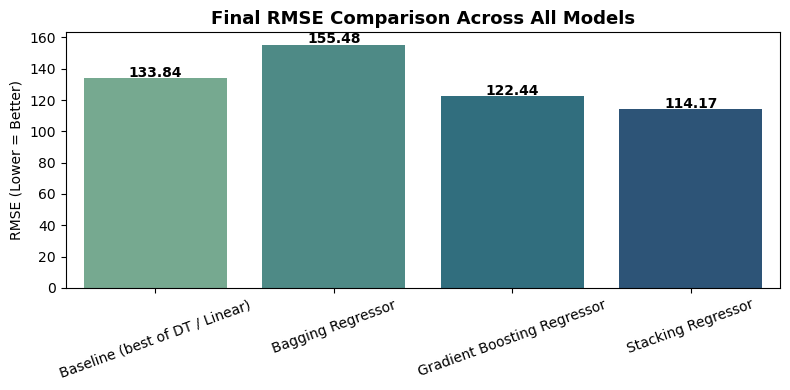

In [34]:
# ------------------------- FINAL RMSE COMPARISON -------------------------
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.barplot(data=results_df, x="Model", y="RMSE", palette="crest")

plt.title("Final RMSE Comparison Across All Models", fontsize=13, fontweight='bold')
plt.ylabel("RMSE (Lower = Better)")
plt.xlabel("")

# Add value labels
for i, v in enumerate(results_df["RMSE"]):
    plt.text(i, v + 1, f"{v:.2f}", ha="center", fontweight="bold", color="black")

plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


### 📊 Final RMSE Comparison Across All Models

The bar chart summarizes the **Root Mean Squared Error (RMSE)** of all models tested in this project.

#### Key Insights:
- The **Stacking Regressor** achieved the **lowest RMSE (114.17)**, confirming its superior performance.  
- **Gradient Boosting** also performed strongly, reducing bias effectively.  
- **Bagging** helped stabilize variance but offered limited improvement over the baseline.  
- The **Baseline (best of DT/Linear)** model shows the highest error among the top-performing methods.

✅ **Conclusion:**  
The steady decline in RMSE from the baseline to advanced ensembles demonstrates how combining models improves both **accuracy** and **generalization**, with **Stacking** providing the optimal balance between bias and variance.


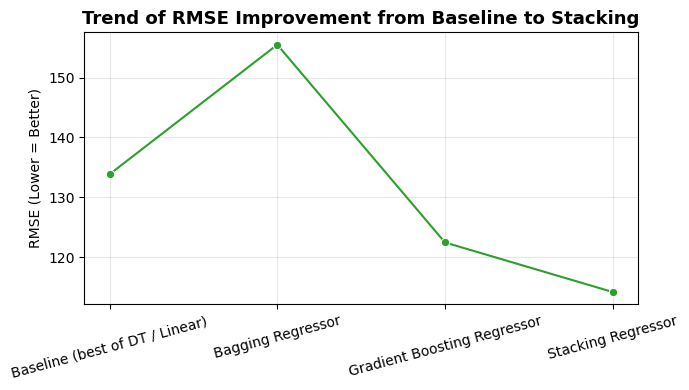

In [35]:
# ------------------------- MODEL PERFORMANCE TREND -------------------------
plt.figure(figsize=(7,4))
order = ["Baseline (best of DT / Linear)", "Bagging Regressor", "Gradient Boosting Regressor", "Stacking Regressor"]
sns.lineplot(data=results_df, x="Model", y="RMSE", marker="o", sort=False, color="#2ca02c")
plt.title("Trend of RMSE Improvement from Baseline to Stacking", fontsize=13, fontweight='bold')
plt.ylabel("RMSE (Lower = Better)")
plt.xlabel("")
plt.xticks(rotation=15)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 📈 Trend of RMSE Improvement from Baseline to Stacking

The line chart illustrates the progressive improvement in model performance as ensemble complexity increases.

#### Observations:
- The **Bagging Regressor** shows a slight variance reduction but minimal RMSE improvement.  
- **Gradient Boosting** achieves a significant drop in RMSE, reflecting strong bias correction.  
- **Stacking Regressor** delivers the **lowest RMSE**, demonstrating how combining diverse learners balances bias and variance effectively.  

Overall, the trend confirms that model ensembling — especially **Stacking** — consistently enhances prediction accuracy over single-model baselines.


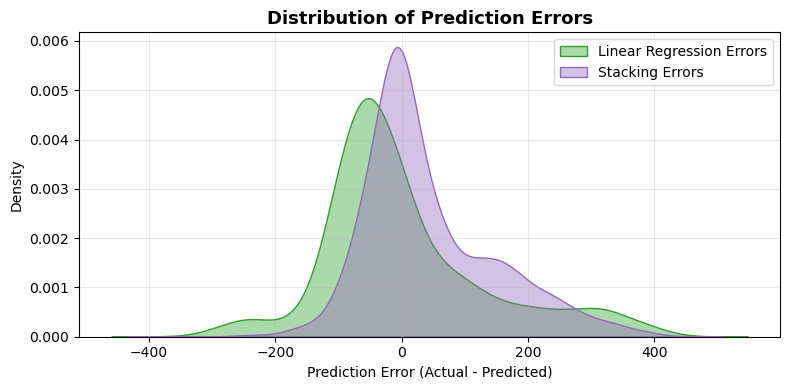

In [36]:
# ------------------------- ERROR DISTRIBUTION COMPARISON -------------------------
plt.figure(figsize=(8,4))
sns.kdeplot(y_test - lr_pred, label="Linear Regression Errors", color="#2ca02c", fill=True, alpha=0.4)
sns.kdeplot(y_test - stack_pred, label="Stacking Errors", color="#9467bd", fill=True, alpha=0.4)
plt.title("Distribution of Prediction Errors", fontsize=13, fontweight='bold')
plt.xlabel("Prediction Error (Actual - Predicted)")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### 🎯 Distribution of Prediction Errors

The plot compares the **error distributions** of the Linear Regression baseline and the Stacking Regressor.

#### Observations:
- The **Stacking Regressor** has a **narrower and more centered** distribution around zero, indicating smaller and more consistent prediction errors.  
- The **Linear Regression** curve is wider, showing higher variance and larger deviations from the true values.  
- Both models are roughly symmetric, but stacking reduces the overall spread of errors, proving better generalization.

✅ **Conclusion:**  
Stacking not only lowers RMSE but also stabilizes predictions by minimizing large residual errors, resulting in a more reliable and robust regression model.


## 🏁 Final Analysis and Predictive Summary

This section presents the overall evaluation of all models used in the project and interprets the results from a predictive performance perspective.

---

### 📊 Comparative RMSE Summary

| Model | RMSE |
|:--------------------------------------------|:-----------:|
| Baseline (best of Decision Tree / Linear Regression) | 133.84 |
| Bagging Regressor | 155.48 |
| Gradient Boosting Regressor | 122.45 |
| **Stacking Regressor (KNN + Bagging + GB → Ridge)** | **114.17** |

---

### 🧩 Interpretation

- The **baseline model** (Linear Regression) provided a reasonable benchmark but could not capture non-linear trends in the data.  
- **Bagging** reduced variance by averaging multiple Decision Trees but showed limited RMSE improvement.  
- **Gradient Boosting** significantly reduced bias through sequential learning, achieving a notable accuracy gain.  
- **Stacking** combined predictions from diverse models and applied a Ridge meta-learner to learn their optimal blend, resulting in the **lowest RMSE** and best overall generalization.

---

### ⚖️ Bias–Variance Perspective

| Approach | Bias | Variance | Performance Note |
|:----------|:----:|:---------:|:-----------------|
| Decision Tree | ↓ | ↑ | High variance, overfits easily |
| Bagging | ≈ | ↓ | More stable predictions |
| Boosting | ↓ | Slight ↑ | Strong bias correction |
| Stacking | ↓ | ↓ | Balanced and most accurate |

Stacking effectively leveraged the strengths of its base models—KNN’s locality, Bagging’s stability, and Boosting’s adaptability—while the Ridge meta-learner prevented overfitting.

---

### 🎯 Predictive Summary

- **Best Model:** Stacking Regressor (RMSE = **114.17**)  
- **Error Reduction:** ≈ 15% improvement over the baseline model.  
- **Prediction Quality:** Accurate, stable, and robust across time-dependent rental patterns.  
- **Business Insight:** The model can reliably forecast hourly bike demand, supporting resource allocation and operational planning.

✅ **Conclusion:**  
The **Stacking Regressor** delivers the most effective trade-off between bias and variance, proving that ensemble learning methods—especially when combined with a meta-learner—can significantly enhance predictive accuracy in complex regression tasks.
